In [1]:
import numpy as np

import random
from scipy import integrate
from scipy import interpolate
from scipy import stats
import matplotlib.pylab as plt
from matplotlib import cm
from matplotlib.ticker import AutoMinorLocator
% matplotlib notebook
import glob
import scipy
from IPython.display import Image

def plot_style(xticks=5,yticks=5):
    
    global ax,fig
    
    plt.rc('text', usetex=True)
    #plt.rcParams['mathtext.fontset'] = 'cm'
    #plt.rcParams['mathtext.rm'] = 'serif'
    plt.rcParams.update({'figure.autolayout': True})
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['axes.linewidth'] = 2
    plt.rcParams['figure.figsize'] = 8, 7.5

    fig,ax = plt.subplots()
    x_minor_locator = AutoMinorLocator(xticks)
    y_minor_locator = AutoMinorLocator(yticks)
    plt.tick_params(which='both', width=1.7)
    plt.tick_params(which='major', length=9)
    plt.tick_params(which='minor', length=5)
    ax.xaxis.set_minor_locator(x_minor_locator)
    ax.yaxis.set_minor_locator(y_minor_locator)
    ax.tick_params(axis='both', which='both', pad=8, left='on', right='on',top='on',bottom='on')

    plt.rcParams['lines.linewidth'] = 1.0
    plt.rcParams['lines.dashed_pattern'] = [6, 6] 
    plt.rcParams['lines.dashdot_pattern'] = [3, 5, 1, 5]
    plt.rcParams['lines.dotted_pattern'] = [1, 3]
    plt.rcParams['lines.scale_dashes'] = False
    plt.rcParams['errorbar.capsize'] = 6

# Loading NS model's data

In [2]:
MSun = 1.98892e33  

_star_model = np.loadtxt('BSK21_1.40.dat', skiprows=1)

_rho = interpolate.interp1d(np.log10(_star_model[:, 1] * 1e5), np.log10(_star_model[:, 3]), kind='linear',bounds_error=False,fill_value=-50)
_nb = interpolate.interp1d(np.log10(_star_model[:, 1] * 1e5), _star_model[:, 5], kind='linear',bounds_error=False,fill_value=0.0)
_ne = interpolate.interp1d(np.log10(_star_model[:, 1] * 1e5), _star_model[:, 6], kind='linear',bounds_error=False,fill_value=0.0)
_nm = interpolate.interp1d(np.log10(_star_model[:, 1] * 1e5), _star_model[:, 7], kind='linear',bounds_error=False,fill_value=0.0)


def rho(a):  # density(radius)     
    return np.power(10,_rho(np.log10(a)))

def nb(a):   # baryon number density(radius)
    return _nb(np.log10(a))

def ne(a):   # electron number density(radius)
    return _ne(np.log10(a))
 
def nm(a):   # muon number density(radius)
    return _nm(np.log10(a))

# INITIAL MAGNETIC FIELD $B$

In [13]:
R = 12.0e5 # cm
c = 3e10 
e = 4.803e-10
B_max = 1e15

def delta(i,j): # the Kronecker delta
    return i==j

In [4]:
def Psy(x,theta): # eq. 48
    return B_max*R*R* (1./2. * x*x - 3./5. * np.power(x,4) + 3./14. * np.power(x,6) ) * np.power(np.sin(theta),2)

In [5]:
def grad_Psy(x, theta, i):
    psy_r = B_max*R* (x - 12./5. * np.power(x,3) + 18./14. * np.power(x,5) ) * np.sin(theta) * np.sin(theta)
    psy_theta = B_max*R* (1./2. * x - 3./5. * np.power(x,3) + 3./14. * np.power(x,5) )* 2 * np.cos(theta) * np.sin(theta)
    return psy_r * delta(1,i) + psy_theta * delta(2,i)

def grad_phi(x, theta ,i):
    return 1./x/R * delta(3,i) / np.sin(theta)

def B_sph(x, theta): # magnetic field B in spherical coordinates' basis
    B_r = grad_Psy(x, theta, 2) * grad_phi(x, theta ,3)
    B_theta = -grad_Psy(x, theta, 1) * grad_phi(x, theta ,3)
    return B_r,B_theta,0.0

def B_cart(x, theta): # magnetic field B in Cartesien coordinates' basis
    B = B_sph(x, theta)
    B_x = np.sin(theta)*B[0] + np.cos(theta)*B[1]  
    B_z = np.cos(theta)*B[0] - np.sin(theta)*B[1]  
    return B_x,0.0,B_z

# Creating two meshes to visualize the initial magnetic field $B$

In [6]:
# main grid
N = 700
r = np.linspace(0.1,0.999,N)
theta = np.linspace(0.001,0.999*np.pi,N)
r_grid,theta_grid = np.meshgrid(r,theta)
r = r_grid.flatten()
theta = theta_grid.flatten()

z_grid = r_grid*np.cos(theta_grid)
x_grid = r_grid*np.sin(theta_grid)

z = r*np.cos(theta)
x = r*np.sin(theta)

# additional grid (only for visualization purposes)
N = 20
r2 = np.linspace(0.1,0.999,N)
theta2 = np.linspace(0.001,0.999*np.pi,N)

r2_grid,theta2_grid = np.meshgrid(r2,theta2)

r2 = r2_grid.flatten()
theta2 = theta2_grid.flatten()

z2 = r2*np.cos(theta2)
x2 = r2*np.sin(theta2)

N = int(np.sqrt(len(r)))

In [7]:
B_ini = np.zeros((3,len(r)))

for i in range(len(r)):
    B_ini[:,i] = B_sph(r[i], theta[i])
    
B_ini_mag = np.sqrt(B_ini[0,:]*B_ini[0,:] + B_ini[1,:]*B_ini[1,:] + B_ini[2,:]*B_ini[2,:])
B_ini_mag_grid = B_ini_mag.reshape((N, N))
print(B_ini_mag)
B_ini_cart_2 = np.zeros((3,len(r2)))
for i in range(len(r2)):
    B_ini_cart_2[:,i] = B_cart(r2[i], theta2[i])

    
print(np.shape(B_ini))
print(np.shape(B_ini_mag))
print(np.shape(B_ini_cart_2))

[9.88042845e+14 9.87734438e+14 9.87422149e+14 ... 2.31037536e+14
 2.30145351e+14 2.29257664e+14]
(3, 490000)
(490000,)
(3, 400)


<IPython.core.display.Javascript object>


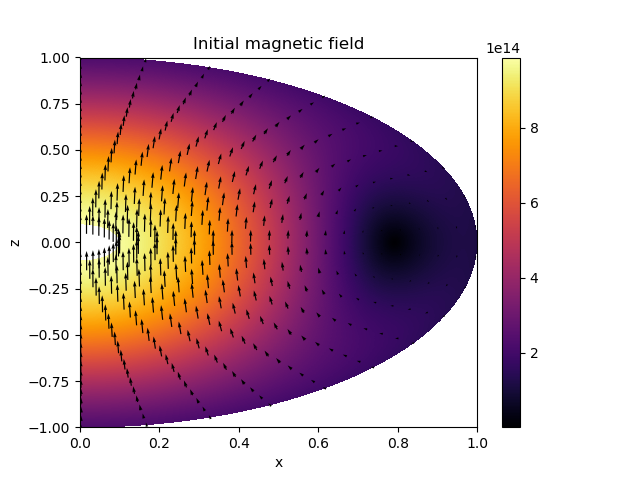

Text(0.5,1,'Initial magnetic field')

In [8]:
plt.figure()
plt.pcolor(x_grid, z_grid, B_ini_mag_grid, cmap=cm.inferno, vmin=B_ini_mag.min(), vmax=B_ini_mag.max())
plt.colorbar()
Q = plt.quiver(x2, z2, B_ini_cart_2[0,:], B_ini_cart_2[2,:], pivot='mid', units='inches')
plt.xlabel('x')
plt.ylabel('z')
plt.title('Initial magnetic field')

# Analytical expressions for the friction coefficients $J_{ep}$ and $J_{np}$

$J_{ep} = 2\times 10^{28} T_8^2 \left(\frac{\rho_0}{\rho}\right)^{5/3} \left(\frac{n_e}{n_0}\right)^{4/3}$ g cm$^{-3}$ s$^{-1}$; $J_{np} = 1.25\times 10^{31} T_8^2 \left(\frac{\rho_0}{\rho}\right)^{1/3} \left(\frac{n_p}{n_0}\right)$ g cm$^{-3}$ s$^{-1}$; $n_0 = 0.16$ fm$^{-3}$; $\rho_0 = 2.8 \times 10^{14}$  g cm$^{-3}$; $T_8 = T/(10^{8}$ K)

In [9]:
rho_0 = 2.8e14 # g cm^-3
n_0 = 0.16

def J_ep(T,rho,n_e):
    T8 = T/1e8 # [K]
    return 2.0e28 * T8 * T8 * np.power(rho_0/rho, 5./3.) * np.power(n_e/n_0, 4./3.) # g cm^-3 s^-1

def J_np(T,rho,n_p):
    T8 = T/1e8 # [K]
    return 1.25e31 * T8 * T8 * np.power(rho_0/rho, 1./3.) * n_p/n_0 # g cm^-3 s^-1 

In [10]:
rho_array = rho(r_grid[0,:]*R)
ne_array = ne(r_grid[0,:]*R)
nb_array = nb(r_grid[0,:]*R)
nm_array = nm(r_grid[0,:]*R)

nn_array = nb_array - nm_array - ne_array
np_array = nb_array - nn_array

ne_array_dot = np.gradient(ne_array,r_grid[0,:]*R)
nb_array_dot = np.gradient(nb_array,r_grid[0,:]*R)

<IPython.core.display.Javascript object>


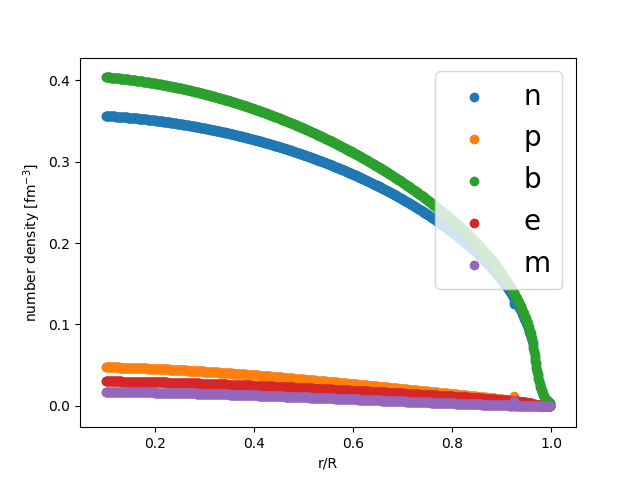

Text(0,0.5,'number density [fm$^{-3}$]')

In [11]:
plt.figure()
plt.scatter(r_grid[0,:],nn_array,label='n')
plt.scatter(r_grid[0,:],np_array,label='p')
plt.scatter(r_grid[0,:],nb_array,label='b')
plt.scatter(r_grid[0,:],ne_array,label='e')
plt.scatter(r_grid[0,:],nm_array,label='m')

plt.legend(fontsize=20, loc='upper right')
plt.xlabel('r/R')
plt.ylabel('number density [fm$^{-3}$]')

# here we take curl of the initial magnetic field and calculate the current $\mathbf{j} = \frac{1}{r}(\frac{\partial}{\partial r}(rB_\theta) - \frac{\partial B_r}{\partial \theta})\mathbf{e}_\varphi$

In [14]:
B_ini_r_grid = B_ini[0,:].reshape((N, N))
B_ini_theta_grid = B_ini[1,:].reshape((N, N))


B_r_grad_theta_grid = np.zeros_like(B_ini_r_grid)
rB_theta_grad_r_grid = np.zeros_like(B_ini_r_grid)
  
for i in range(N):
    rB_theta_grad_r_grid[i,:] = np.gradient(r_grid[i,:]*B_ini_theta_grid[i,:],r_grid[i,:]) 
    B_r_grad_theta_grid[:,i] = np.gradient(B_ini_r_grid[:,i],theta_grid[:,i]) 

curl_B_grid = (rB_theta_grad_r_grid - B_r_grad_theta_grid)/R/r_grid # curl B is pointing along yth direction
j_grid = curl_B_grid * c / 4 / np.pi

<IPython.core.display.Javascript object>


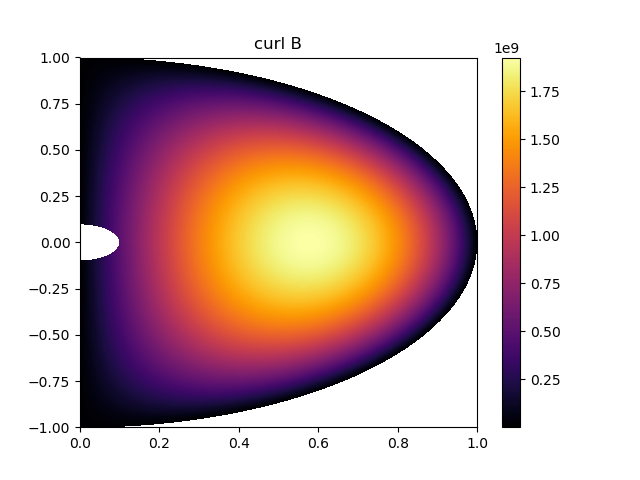

In [27]:
plt.figure()
plt.pcolor(x_grid, z_grid, curl_B_grid, cmap=cm.inferno)
plt.title('curl B')
plt.colorbar()

# the Ampere force $f_A = \frac{1}{c} [j\times B]$;       $f_{Ar} = -\frac{1}{c}jB_\theta$,   $f_{A\varphi} = 0$,  $f_{A\theta} = \frac{1}{c}jB_r$

In [16]:
f_Ar_grid = -j_grid*B_ini_theta_grid / c
f_Atheta_grid = j_grid*B_ini_r_grid / c

# Calculating $r\int\limits_0^\theta f_{A\theta} d\theta$ and $\frac{\partial}{\partial r}( r\int\limits_0^\theta f_{A\theta} d\theta) - f_{Ar}$; $\zeta(r) = 0$

In [17]:
integral = np.zeros_like(f_Ar_grid)

for i in range(N):
    integral[i,:] = np.trapz(f_Atheta_grid[:i,:], theta_grid[:i,:], axis=0)
    
eq23a = R*r_grid*integral
eq23b = np.zeros_like(eq23a)

for i in range(N):
    eq23b[i,:] =  np.gradient(r_grid[i,:]*integral[i,:],r_grid[i,:]) - f_Ar_grid[i,:]

# Finally we are able to compute $\delta \mu_n$ and $\Delta \mu$

$\begin{pmatrix}
n_b & n_e \\
n_b' & n_e' \\
\end{pmatrix} 
\begin{pmatrix} \delta \mu_n \\ \Delta \mu \end{pmatrix} = 
\begin{pmatrix}
r\int\limits_0^\theta f_{A\theta} d\theta \\
\frac{\partial}{\partial r}( r\int\limits_0^\theta f_{A\theta} d\theta) - f_{Ar} \\
\end{pmatrix}, \quad \begin{pmatrix} \delta \mu_n \\ \Delta \mu \end{pmatrix} =  \frac{1}{n_b n_e' - n_e n_b'} \begin{pmatrix}
n_e' & -n_e \\
-n_b' & n_b \\
\end{pmatrix}\begin{pmatrix}
r\int\limits_0^\theta f_{A\theta} d\theta \\
\frac{\partial}{\partial r}( r\int\limits_0^\theta f_{A\theta} d\theta) - f_{Ar} \\
\end{pmatrix}$

In [18]:
delta_mu_n = np.zeros_like(eq23a)
Delta_mu = np.zeros_like(eq23a)

det = nb_array * ne_array_dot - ne_array * nb_array_dot

for i in range(N):
    delta_mu_n[i,:] = 1./det * ( ne_array_dot * eq23a[i,:] - ne_array * eq23b[i,:] )
    Delta_mu[i,:]   = 1./det * ( -nb_array_dot * eq23a[i,:] + nb_array * eq23b[i,:] )

# Nextly we calculate the baryon velocity $U_b$

$V = \frac{n_b}{n_b' n_e - n_e' n_b}\left[div\left( \frac{n_n^2 n_e}{n_b J_{np}}\nabla \delta \mu_n \right) + \Delta \Gamma \right]$, We consider $\Gamma = 0$, $T = 10^8$ K

In [19]:
T = 1e8 # K

grad_r_delta_mu_n = np.zeros_like(delta_mu_n)
grad_theta_delta_mu_n = np.zeros_like(delta_mu_n)

for i in range(N):
    grad_r_delta_mu_n[i,:] = np.gradient(delta_mu_n[i,:],R*r_grid[i,:])
    grad_theta_delta_mu_n[:,i] = np.gradient(delta_mu_n[:,i],theta_grid[:,i])/r_grid[:,i]/R
    
J_np_array = J_np(T,rho_array,np_array)

prefactor = nn_array * nn_array * ne_array / nb_array / J_np_array

V_radial = np.zeros_like(delta_mu_n)
V_angular = np.zeros_like(delta_mu_n)

for i in range(N):
    V_radial[i,:]  = -nb_array/det * np.gradient(prefactor * r_grid[i,:] * r_grid[i,:] * grad_r_delta_mu_n[i,:], 
    r_grid[i,:]*R) / r_grid[i,:] / r_grid[i,:]
    V_angular[:,i] = -nb_array[i]/det[i] * prefactor[i] * np.gradient( np.sin(theta_grid[:,i]) * 
    grad_theta_delta_mu_n[:,i], theta_grid[:,i]) / np.sin(theta_grid[:,i]) /  r_grid[:,i] / R 

V = V_radial + V_angular

$U_{br} = V, \quad U_{b\theta} = \frac{1}{n_b r \sin{\theta}} \frac{\partial}{\partial r} \left( n_b r^2 \int\limits_0^\theta V \sin{\theta} d\theta\right)$, $U_{b \varphi} = \frac{j_\varphi}{e n_e}$

In [20]:
U_br = V
U_bphi = np.zeros_like(V)
U_btheta = np.zeros_like(V)

integral2 = np.zeros_like(V)

for i in range(N):
    integral2[i,:] = np.trapz(V[:i,:]*np.sin(theta_grid[:i,:]), theta_grid[:i,:], axis=0)
    
for i in range(N):
    U_bphi[i,:] = j_grid[i,:]/ ne_array /e
    U_btheta[i,:] = np.gradient(nb_array*r_grid[i,:]*r_grid[i,:]*integral2[i,:],
                                r_grid[i,:]) / nb_array / r_grid[i,:] / np.sin(theta_grid[i,:])

<IPython.core.display.Javascript object>


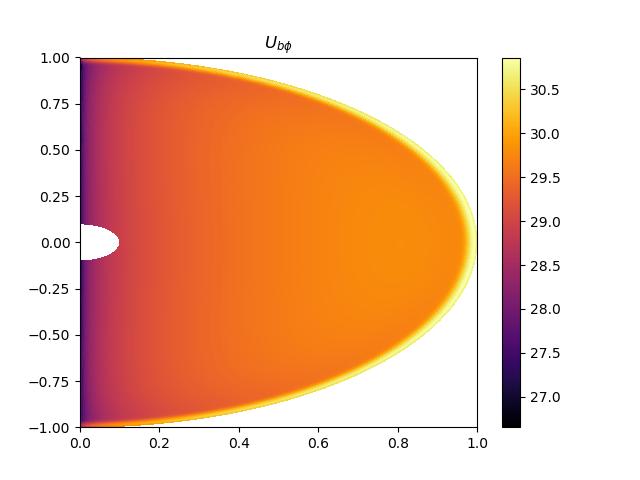

Text(0.5,1,'$U_{b \\phi}$')

In [31]:
plt.figure()
plt.pcolor(x_grid, z_grid, np.log10(np.abs(U_bphi)), cmap=cm.inferno)
plt.colorbar()
plt.title('$U_{b \phi}$')